# Project Description - Automatic Steel Defects classification and localization

**Introduction** <br>
This is a project of defects classification/localization for steel defects on the GC10-DET surface dataset using transfer learning. VGG16 is used for training the dataset. 

**Outline** <br>
This project will have the presentation outlined as follows,
1. Dataset visualization
2. Model training and validation
3. Model testing
4. Results evaluation
5. Model prediction

In [1]:
# Import necessary libraries

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import random
import os
from matplotlib.patches import Rectangle
from matplotlib import pyplot
!pip install lxml 
from lxml import etree

# Enable Matplotlib backend for displaying static images
%matplotlib inline

import subprocess

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input

########################################################################

In [2]:
import csv
import xml.etree.ElementTree as ET

Las siguientes líneas sólo se deben ejecutar la primera vez. De esta forma se descomprimen y organizan los datos adecuadamente.

In [3]:
#!mkdir '/content/sample_data/Metal'
#!unzip -q '/content/drive/My Drive/Colab Notebooks/Computer Vision course/DL/images/Metallic database.zip' -d '/content/sample_data/Metal/images'
#!mv  -v '/content/sample_data/Metal/images/label' '/content/sample_data/Metal/label'

In [4]:
STORAGE_BUCKET = 'mia-deeplearningproject'
DATA_PATH = 'Metallic database'
LOCAL_PATH = '/tmp'
PROJECT_ID = 'braided-rush-338015'


# Download dataset
subprocess.call([
  'gsutil', '-m', 'cp', '-r',
  # Storage path
  os.path.join('gs://', STORAGE_BUCKET, DATA_PATH),
  # Local path
  LOCAL_PATH
])
# Read all the images and count the number of image paths in the training subfolders
image_path = glob.glob(os.path.join(LOCAL_PATH, DATA_PATH, "images/*/*.jpg"))
image_path = [f.replace('\\','/') for f in image_path]
print(f'image_path {len(image_path)}',flush=True)

# Read all the annotation files and count the number of annotations in the training label folder

xmls_path = glob.glob(os.path.join(LOCAL_PATH, DATA_PATH, "label/*.xml"))
xmls_path = [f.replace('\\','/') for f in xmls_path]
print(f'xmls_path {len(xmls_path)}',flush=True)

Copying gs://mia-deeplearningproject/Metallic database/images/Crease/img_01_3436789500_00004.jpg...
Copying gs://mia-deeplearningproject/Metallic database/images/Crease/img_01_425501700_00022.jpg...
Copying gs://mia-deeplearningproject/Metallic database/images/Crease/img_01_425382900_00002.jpg...
Copying gs://mia-deeplearningproject/Metallic database/images/Crease/img_01_429539000_00002.jpg...
Copying gs://mia-deeplearningproject/Metallic database/images/Crease/img_01_4403690400_00005.jpg...
Copying gs://mia-deeplearningproject/Metallic database/images/Crease/img_01_4402116900_00003.jpg...
Copying gs://mia-deeplearningproject/Metallic database/images/Crease/img_01_4402117100_00006.jpg...
Copying gs://mia-deeplearningproject/Metallic database/images/Crease/img_01_4402117200_00003.jpg...
Copying gs://mia-deeplearningproject/Metallic database/images/Crease/img_01_4402270500_00004.jpg...
Copying gs://mia-deeplearningproject/Metallic database/images/Crease/img_01_4402270500_00003.jpg...
Cop

image_path 2280
xmls_path 2280


Data augmentation starts here

In [5]:
# Function that will extract column data for our CSV file as pandas DataFrame
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            try:
                value = (root.find('filename').text,
                         int(root.find('size')[0].text),
                         int(root.find('size')[1].text),
                         member[0].text,
                         int(member[4][0].text),
                         int(member[4][1].text),
                         int(member[4][2].text),
                         int(member[4][3].text)
                         )
                xml_list.append(value)
            except:
                pass
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df
   
# apply the function to convert all XML files in images/ folder into labels.csv
DATA_PATH = 'Metallic database'
LOCAL_PATH = '/tmp'
labels_df = xml_to_csv('/tmp/Metallic database/label/')
labels_df.to_csv(('labels.csv'), index=None)

In [6]:
len(labels_df)

3542

In [7]:
pip install imgaug

Note: you may need to restart the kernel to use updated packages.


In [8]:
import imageio
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
import imgaug as ia
ia.seed(1)

#Function that returns images filename folder name.
def folderfinder(filename, path):
    for root, dirs, files in os.walk(path):
        if filename in files:
            return os.path.join(root)
        
# function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

#Define the augmentor...
aug = iaa.SomeOf(2, [    
    iaa.Affine(scale=(0.5, 1.5)),
    iaa.Affine(translate_percent={"x":(-0.3, 0.3),"y":(-0.3, 0.3)}),
    iaa.Fliplr(1),
    iaa.Multiply((0.5, 1.5)),
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))
])

In [9]:
#Data augmentation:
import re

def image_aug(df, images_path, image_prefix, augmentor):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')
    
    for filename in df['filename'].unique():
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   
        
        folder=folderfinder(filename,images_path)
    #   read the image
        image = imageio.imread(folder+'/'+filename)
    #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
    #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane    
        bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()
        
    #   don't perform any actions with the image if there are no bounding boxes left in it    
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass
        
    #   otherwise continue
        else:
        #   write augmented image to a file
            imageio.imwrite(folder+'/'+image_prefix+filename, image_aug)  
            
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
    
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [10]:
#Applying data augmentation

df_augmented=image_aug(labels_df, os.path.join(LOCAL_PATH, DATA_PATH,"images/") , 'AUGMENTED', aug)
df_augmented.to_csv(('labels_augemted.csv'), index=None)

In [11]:
df_augmented =df_augmented.dropna(axis=0)

In [12]:
df_augmented.xmin = df_augmented.xmin.astype(int)
df_augmented.ymin = df_augmented.ymin.astype(int)
df_augmented.xmax = df_augmented.xmax.astype(int)
df_augmented.ymax = df_augmented.ymax.astype(int)

In [13]:
df_augmented.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,AUGMENTEDimg_03_425501800_01202.jpg,2048,1000,7_yiwu,420,30,494,98
1,AUGMENTEDimg_03_425501800_01202.jpg,2048,1000,7_yiwu,533,162,608,219
2,AUGMENTEDimg_02_3436813700_00307.jpg,2048,1000,4_shuiban,499,9,862,775
3,AUGMENTEDimg_02_SIS001491_00257.jpg,2048,1000,6_siban,0,0,60,469
4,AUGMENTEDimg_07_4404613900_01090.jpg,2048,1000,2_hanfeng,0,682,2048,793


In [14]:
#Convert CSV to XML files.
#len(Aug_df_unique)
for i in range(0,len(df_augmented)):
    height = df_augmented['height'].iloc[i]
    width = df_augmented['width'].iloc[i]
    depth=1

    annotation = ET.Element('annotation')
    ET.SubElement(annotation, 'filename').text = str(df_augmented['filename'].iloc[i])
    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str(width)
    ET.SubElement(size, 'height').text = str(height)
    ET.SubElement(size, 'depth').text = str(depth)
    ob = ET.SubElement(annotation, 'object')
    ET.SubElement(ob, 'name').text = str(df_augmented['class'].iloc[i])
    ET.SubElement(ob, 'pose').text = 'Unspecified'
    ET.SubElement(ob, 'truncated').text = '0'
    ET.SubElement(ob, 'difficult').text = '0'
    bbox = ET.SubElement(ob, 'bndbox')
    ET.SubElement(bbox, 'xmin').text = str(df_augmented['xmin'].iloc[i])
    ET.SubElement(bbox, 'ymin').text = str(df_augmented['ymin'].iloc[i])
    ET.SubElement(bbox, 'xmax').text = str(df_augmented['xmax'].iloc[i])
    ET.SubElement(bbox, 'ymax').text = str(df_augmented['ymax'].iloc[i])
    

    fileName = str(df_augmented['filename'].iloc[i])
    tree = ET.ElementTree(annotation)
    tree.write('/tmp/Metallic database/label/'+fileName+'.xml')

In [15]:
xmls_path=glob.glob(os.path.join(LOCAL_PATH, DATA_PATH, "label/*.xml"))
len(xmls_path)

4468

In [16]:
image_path=glob.glob(os.path.join(LOCAL_PATH, DATA_PATH, "images/*/*.jpg"))
len(image_path)

4468

Finish Data augmentation

In [5]:
# Sort the annotation and image files in ascending order

xmls_path.sort(key = lambda x:x.split("/")[-1].split(".xml")[0])
image_path.sort(key = lambda x:x.split("/")[-1].split(".jpg")[0])

In [6]:
# Extract the annotation filename without file extension
xmls_train = [path.split("/")[-1].split(".")[0] for path in xmls_path]
xmls_train[:5]

['img_01_3402617700_00001',
 'img_01_3402617700_01009',
 'img_01_3436789500_00004',
 'img_01_3436814600_00259',
 'img_01_3436815300_00473']

In [7]:
# Retrieve the image filename to match the annotation file counts
# Ensure unique counts of training images with the annotations

imgs_train = [img for img in image_path if (img.split("/")[-1].split)(".jpg")[0] in xmls_train]
imgs_train[:5]

['/tmp/Metallic database/images/Crescent gap/img_01_3402617700_00001.jpg',
 '/tmp/Metallic database/images/Crescent gap/img_01_3402617700_01009.jpg',
 '/tmp/Metallic database/images/Crease/img_01_3436789500_00004.jpg',
 '/tmp/Metallic database/images/Silk spot/img_01_3436814600_00259.jpg',
 '/tmp/Metallic database/images/Silk spot/img_01_3436815300_00473.jpg']

In [8]:
len(imgs_train),len(xmls_train)

(2280, 2280)

In [9]:
# Extract label names as DataFrame column

labels = [label.split("/")[-2] for label in imgs_train]
labels[:5]

['Crescent gap', 'Crescent gap', 'Crease', 'Silk spot', 'Silk spot']

In [10]:
labels = pd.DataFrame(labels, columns = ["Defect Type"])
labels

,Defect Type
0,Crescent gap
1,Crescent gap
2,Crease
3,Silk spot
4,Silk spot
...,...
2275,Silk spot
2276,Silk spot
2277,Silk spot
2278,Silk spot


In [11]:
# One-hot encoding for multiple classes
from sklearn.preprocessing import LabelBinarizer

# Obtain training labels without duplication
Class = labels["Defect Type"].unique()
# Store data values in key:value pairs with Python dictionaries
Class_dict = dict(zip(Class, range(1,len(Class) + 1)))
labels["Class"] = labels["Defect Type"].apply(lambda x: Class_dict[x])

lb = LabelBinarizer()
# Fit label binarizer
lb.fit(list(Class_dict.values()))
# Convert multi-class labels to binary labels (belong or does not belong to the class)
transformed_labels = lb.transform(labels["Class"])
y_bin_labels = []  

for i in range(transformed_labels.shape[1]):
    y_bin_labels.append("Class" + str(i))
    labels["Class" + str(i + 1)] = transformed_labels[:, i]

In [12]:
Class_dict

{'Crescent gap': 1,
 'Crease': 2,
 'Silk spot': 3,
 'Water spot': 4,
 'Welding line': 5,
 'Inclusion': 6,
 'Oil spot': 7,
 'Waist folding': 8,
 'Rolled pit': 9,
 'Punching hole': 10}

In [13]:
labels.drop("Class", axis = 1, inplace = True)
labels.drop("Defect Type", axis = 1, inplace = True)
labels.head()

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [14]:
# Function to parse and extract information from annotation files

def to_labels(path):
    # Read the annotation file
    xml = open("{}".format(path)).read()                         
    sel = etree.HTML(xml)
    # Obtain the image width
    width = int(sel.xpath("//size/width/text()")[0])
    # Obtain the image height
    height = int(sel.xpath("//size/height/text()")[0])  
    # Extract the bounding box coordinates
    xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
    xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
    ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
    ymax = int(sel.xpath("//bndbox/ymax/text()")[0])
    # Return the relative coordinates
    return [xmin/width, ymin/height, xmax/width, ymax/height]

In [15]:
# Display the relative bounding box coordinates
coors = [to_labels(path) for path in xmls_path]
coors[:5]

[[0.8486328125, 0.806, 0.951171875, 0.993],
 [0.857421875, 0.298, 0.96044921875, 0.858],
 [0.47900390625, 0.182, 0.9990234375, 0.249],
 [0.3642578125, 0.017, 0.49365234375, 0.993],
 [0.3974609375, 0.017, 0.7431640625, 0.978]]

In [16]:
# Set four coordinate points as outputs

xmin, ymin, xmax, ymax = list(zip(*coors))

# Convert to Numpy array
xmin = np.array(xmin)
ymin = np.array(ymin)
xmax = np.array(xmax)
ymax = np.array(ymax)
label = np.array(labels.values)
label

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [17]:
label.shape

(2280, 10)

In [18]:
# Creates a Dataset whose elements are slices of the given tensors
# Slicing a 1D tensor produces scalar tensor elements

labels_dataset = tf.data.Dataset.from_tensor_slices((xmin, ymin, xmax, ymax, label))
labels_dataset

2022-01-25 19:54:22.701174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 19:54:22.830749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 19:54:22.831650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 19:54:22.836002: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

<TensorSliceDataset shapes: ((), (), (), (), (10,)), types: (tf.float64, tf.float64, tf.float64, tf.float64, tf.int64)>

In [19]:
# Load the image from image path

def load_image(path):
    image = tf.io.read_file(path)                           
    image = tf.image.decode_jpeg(image,3)               
    image = tf.image.resize(image,[224,224])               
    image = tf.cast(image,tf.float32)  
    image = image / 255
    return image

In [20]:
# Build the dataset

dataset = tf.data.Dataset.from_tensor_slices(imgs_train)
dataset = dataset.map(load_image)

dataset_label = tf.data.Dataset.zip((dataset, labels_dataset))
dataset_label

<ZipDataset shapes: ((224, 224, 3), ((), (), (), (), (10,))), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64, tf.int64))>

In [21]:
# Shuffle the images and extract the images by the defined batch size

batch_size = 32
dataset_label = dataset_label.repeat().shuffle(500).batch(batch_size)
#dataset_label = dataset_label.shuffle(500).batch(batch_size)

# Creates a Dataset that prefetches elements from this dataset
# Most dataset input pipelines should end with a call to prefetch
# This allows later elements to be prepared while the current element is being processed
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements
#AUTOTUNE = tf.data.experimental.AUTOTUNE

#dataset_label = dataset_label.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
# Split the dataset into 80% for training and 20% for testing

train_count = int(len(imgs_train) * 0.8)
test_count = int(len(imgs_train) * 0.2)
train_count, test_count

(1824, 456)

In [23]:
train_dataset = dataset_label.skip(test_count)
test_dataset = dataset_label.take(test_count)

In [24]:
train_dataset

<SkipDataset shapes: ((None, 224, 224, 3), ((None,), (None,), (None,), (None,), (None, 10))), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64, tf.int64))>

In [25]:
test_dataset

<TakeDataset shapes: ((None, 224, 224, 3), ((None,), (None,), (None,), (None,), (None, 10))), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64, tf.int64))>

In [26]:
class_dict = {v:k for k,v in Class_dict.items()}
class_dict

{1: 'Crescent gap',
 2: 'Crease',
 3: 'Silk spot',
 4: 'Water spot',
 5: 'Welding line',
 6: 'Inclusion',
 7: 'Oil spot',
 8: 'Waist folding',
 9: 'Rolled pit',
 10: 'Punching hole'}

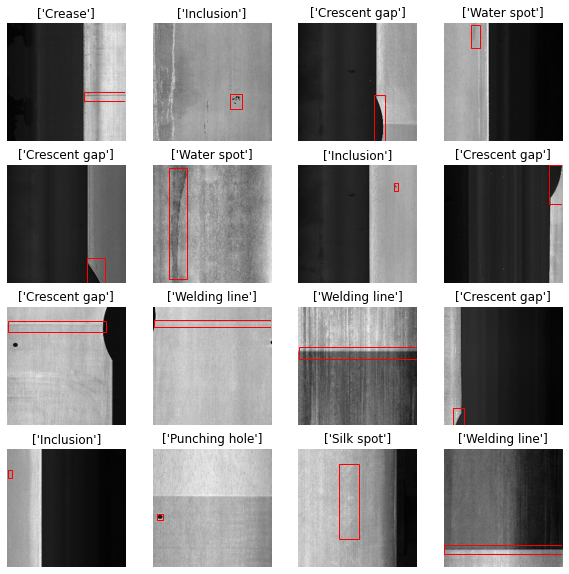

In [27]:
# Display a sample training image with its label
pyplot.figure(figsize=(10, 10))

for img,label in train_dataset.take(1):
  for i in range(16):

    ax = pyplot.subplot(4, 4, i + 1)    
    plt.imshow(keras.preprocessing.image.array_to_img(img[i]))     
    out1, out2, out3, out4, out5 = label                         
    xmin, ymin, xmax, ymax = out1[i].numpy()*224, out2[i].numpy()*224, out3[i].numpy()*224, out4[i].numpy()*224
    rect = Rectangle((xmin,ymin),(xmax - xmin),(ymax - ymin), fill = False, color = "r")  
    ax = plt.gca()                      
    ax.axes.add_patch(rect)   
    pred_imglist = []
    pred_imglist.append(class_dict[np.argmax(out5[i])+1])
    plt.title(pred_imglist)
    pyplot.axis("off")

    #plt.show()

**i. VGG16**

In [28]:
# Import VGG16 model with pre-trained weights from ImageNet

base_vgg16 = tf.keras.applications.ResNet152V2(weights = "imagenet",
                                         include_top = False,
                                         input_shape = (224,224,3),
                                         pooling = 'avg')

In [29]:
# Train only  fully-connected layers
base_vgg16.trainable = False

In [30]:
# Define the base model with fully-connected layers
inputs = keras.Input(shape = (224,224,3))
x = base_vgg16(inputs)

x1 = keras.layers.Dense(1024, activation = "relu")(x)
x1 = keras.layers.Dense(512, activation = "relu")(x1)
#x1 = keras.layers.Dense(512, activation = "relu")(x1)
#x1 = keras.layers.Dense(256, activation = "relu")(x1)
out1 = keras.layers.Dense(1, name = "xmin")(x1)
out2 = keras.layers.Dense(1, name = "ymin")(x1)
out3 = keras.layers.Dense(1, name = "xmax")(x1)
out4 = keras.layers.Dense(1, name = "ymax")(x1)

x2 = keras.layers.Dense(1024,activation = "relu")(x)
x2 = keras.layers.Dense(512,activation = "relu")(x2)
#x2 = keras.layers.Dense(512,activation = "relu")(x2)
#x2 = keras.layers.Dense(256,activation = "relu")(x2)
out_class = keras.layers.Dense(10,activation = "softmax", name = "class")(x2)

out = [out1, out2, out3, out4, out_class]

vgg16 = keras.models.Model(inputs = inputs, outputs = out)
vgg16.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet152v2 (Functional)       (None, 2048)         58331648    ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)         2098176     ['resnet152v2[0][0]']            
                                                                                                  
 dense_2 (Dense)                (None, 1024)         2098176     ['resnet152v2[0][0]']        

In [31]:
# Compile the model with optimizer and loss functions

vgg16.compile(keras.optimizers.Adam(0.0005),
              loss = {"xmin": "mse",
                      "ymin": "mse",
                      "xmax": "mse",
                      "ymax": "mse",
                      "class": "categorical_crossentropy"},
              metrics = ["mae","acc"])

In [32]:
# Reduce learning rate

#lr_reduce = keras.callbacks.ReduceLROnPlateau("val_loss", patience = 5, factor = 0.5, min_lr = 1e-6)

In [33]:
# Start training the model
#callbacks = [lr_reduce]
history = vgg16.fit(train_dataset,
                    steps_per_epoch = train_count//batch_size,
                    batch_size=batch_size,
                    epochs = 22,
                    validation_data = test_dataset,
                    validation_steps = test_count//batch_size)

Epoch 1/22


2022-01-25 19:56:41.770327: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


57/57 [==============================] - 91s 761ms/step - loss: 1.4045 - xmin_loss: 0.0888 - ymin_loss: 0.0592 - xmax_loss: 0.1690 - ymax_loss: 0.1075 - class_loss: 0.9800 - xmin_mae: 0.2310 - xmin_acc: 0.0000e+00 - ymin_mae: 0.1881 - ymin_acc: 0.0000e+00 - xmax_mae: 0.2800 - xmax_acc: 0.0817 - ymax_mae: 0.2471 - ymax_acc: 0.0652 - class_mae: 0.0908 - class_acc: 0.6820 - val_loss: 0.7292 - val_xmin_loss: 0.0463 - val_ymin_loss: 0.0300 - val_xmax_loss: 0.0447 - val_ymax_loss: 0.0478 - val_class_loss: 0.5604 - val_xmin_mae: 0.1671 - val_xmin_acc: 0.0000e+00 - val_ymin_mae: 0.1334 - val_ymin_acc: 0.0000e+00 - val_xmax_mae: 0.1593 - val_xmax_acc: 0.1027 - val_ymax_mae: 0.1616 - val_ymax_acc: 0.1205 - val_class_mae: 0.0588 - val_class_acc: 0.8125
Epoch 2/22
57/57 [==============================] - 40s 708ms/step - loss: 0.7812 - xmin_loss: 0.0522 - ymin_loss: 0.0380 - xmax_loss: 0.0504 - ymax_loss: 0.0475 - class_loss: 0.5932 - xmin_mae: 0.1747 - xmin_acc: 0.0000e+00 - ymin_mae: 0.1525 - ym

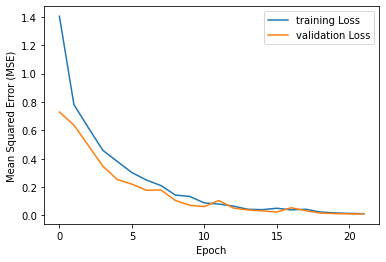

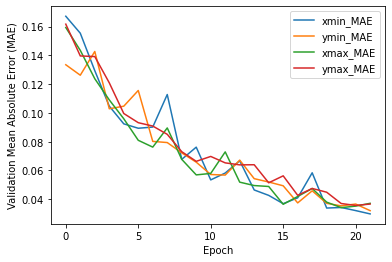

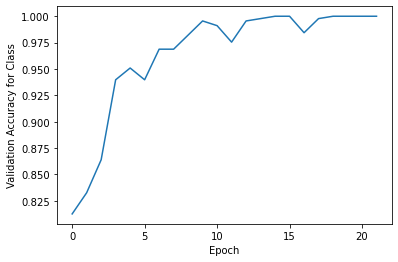

In [34]:
# Visualize the results after training

def plot_history(history):                
    hist = pd.DataFrame(history.history)           
    hist["epoch"] = history.epoch
    
    plt.figure()                                     
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error (MSE)")               
    plt.plot(hist["epoch"], hist["loss"], label = "training Loss")
    plt.plot(hist["epoch"], hist["val_loss"], label = "validation Loss")                           
    plt.legend()
    
    plt.figure()                                      
    plt.xlabel("Epoch")
    plt.ylabel("Validation Mean Absolute Error (MAE)")               
    plt.plot(hist["epoch"], hist["val_xmin_mae"], label = "xmin_MAE")
    plt.plot(hist["epoch"], hist["val_ymin_mae"], label = "ymin_MAE")
    plt.plot(hist["epoch"], hist["val_xmax_mae"], label = "xmax_MAE")
    plt.plot(hist["epoch"], hist["val_ymax_mae"], label = "ymax_MAE")
    plt.legend()      
    
    plt.figure()                                      
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy for Class")               
    plt.plot(hist["epoch"],hist["val_class_acc"], label = "class_accuracy")
    
    plt.show()
    
plot_history(history)  

In [35]:
results = vgg16.evaluate(test_dataset)

456/456 [==============================] - 251s 548ms/step - loss: 0.0108 - xmin_loss: 0.0018 - ymin_loss: 0.0021 - xmax_loss: 0.0021 - ymax_loss: 0.0031 - class_loss: 0.0016 - xmin_mae: 0.0320 - xmin_acc: 0.0000e+00 - ymin_mae: 0.0344 - ymin_acc: 0.0000e+00 - xmax_mae: 0.0353 - xmax_acc: 0.0922 - ymax_mae: 0.0412 - ymax_acc: 0.0781 - class_mae: 3.1983e-04 - class_acc: 1.0000


In [36]:
hist = pd.DataFrame(history.history)           
hist["epoch"] = history.epoch
hist["epoch"]

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
Name: epoch, dtype: int64

In [37]:
print("MAE of xmin value in test set:{}".format(results[6]))
print("MAE of ymin value in test set:{}".format(results[8]))
print("MAE of xmax value in test set:{}".format(results[10]))
print("MAE of ymax value in test set:{}".format(results[12]))
print("Testing accuracy of predicted label:{}".format(results[15]))

MAE of xmin value in test set:0.032011568546295166
MAE of ymin value in test set:0.03436988219618797
MAE of xmax value in test set:0.03526291251182556
MAE of ymax value in test set:0.04124003276228905
Testing accuracy of predicted label:1.0


In [38]:
#vgg16.save("vgg16.h5")

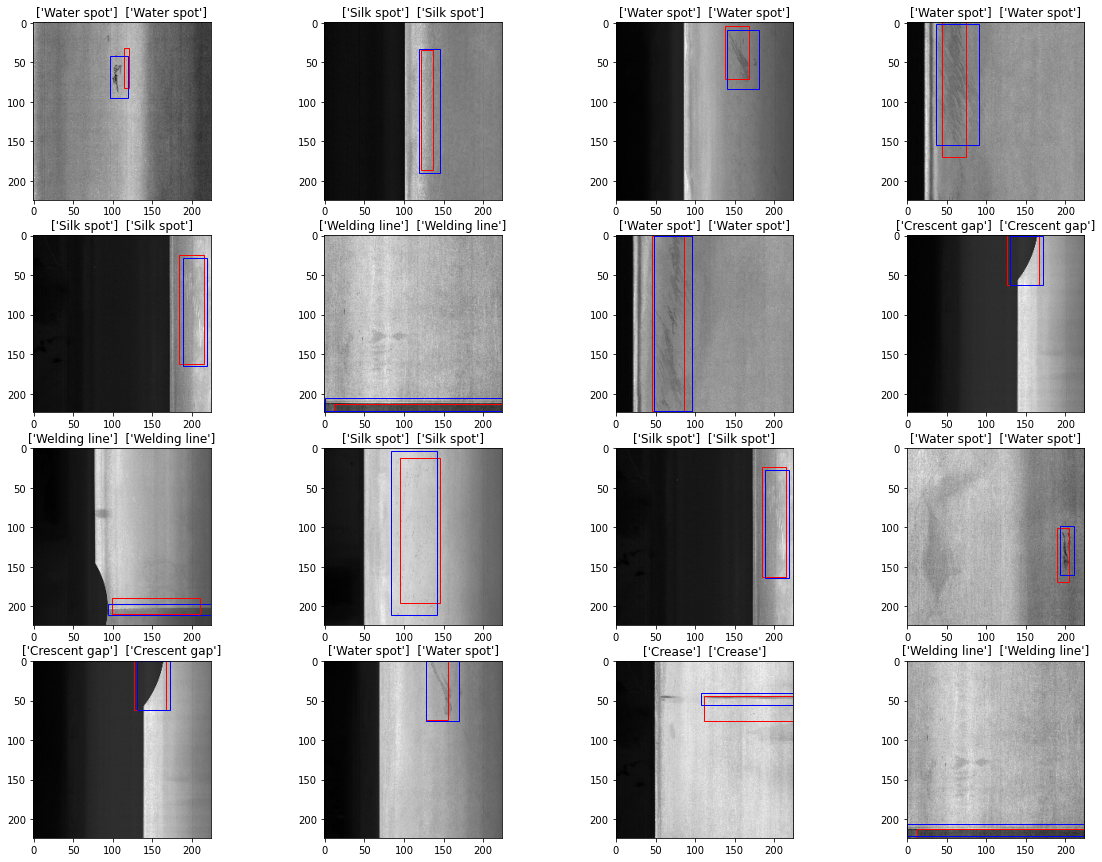

In [48]:
# generate random integer values
from random import seed
from random import randint
seed(1)

plt.figure(figsize = (20, 15))
for img, GT in test_dataset.take(1):
    out1, out2, out3, out4, out5 = vgg16.predict(img)
    out1_gt, out2_gt, out3_gt, out4_gt, out5_gt = GT                         

    for i in range(16):
        num=randint(0, batch_size)
        plt.subplot(4, 4, i + 1)            
        plt.imshow(keras.preprocessing.image.array_to_img(img[num]))    
        pred_imglist = []
        pred_imglist.append(class_dict[np.argmax(out5[num]) + 1])

        gt_list=[]
        gt_list.append(class_dict[np.argmax(out5_gt[num]) + 1])
        plt.title('{0}  {1}'.format(gt_list, pred_imglist))

        xmin, ymin, xmax, ymax = out1[num]*224, out2[num]*224, out3[num]*224, out4[num]*224
        rect = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r") 

        xmin, ymin, xmax, ymax = out1_gt[num]*224, out2_gt[num]*224, out3_gt[num]*224, out4_gt[num]*224
        rect2 = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "b") 

        ax = plt.gca()                   
        ax.axes.add_patch(rect)
        ax.axes.add_patch(rect2)

In [40]:
# Append all the true labels into a list

true_labels = []

for _, label in test_dataset:    
    out1, out2, out3, out4, out5 = label                              
    true_labels.append(class_dict[np.argmax(out5) + 1])

In [41]:
true_labels

['Silk spot',
 'Water spot',
 'Inclusion',
 'Crescent gap',
 'Silk spot',
 'Silk spot',
 'Water spot',
 'Oil spot',
 'Water spot',
 'Inclusion',
 'Welding line',
 'Silk spot',
 'Silk spot',
 'Inclusion',
 'Water spot',
 'Welding line',
 'Water spot',
 'Silk spot',
 'Water spot',
 'Inclusion',
 'Silk spot',
 'Punching hole',
 'Crescent gap',
 'Water spot',
 'Silk spot',
 'Silk spot',
 'Water spot',
 'Welding line',
 'Silk spot',
 'Inclusion',
 'Crescent gap',
 'Welding line',
 'Silk spot',
 'Welding line',
 'Silk spot',
 'Silk spot',
 'Silk spot',
 'Punching hole',
 'Welding line',
 'Silk spot',
 'Welding line',
 'Waist folding',
 'Punching hole',
 'Silk spot',
 'Waist folding',
 'Punching hole',
 'Punching hole',
 'Water spot',
 'Silk spot',
 'Waist folding',
 'Silk spot',
 'Oil spot',
 'Silk spot',
 'Waist folding',
 'Silk spot',
 'Silk spot',
 'Oil spot',
 'Oil spot',
 'Oil spot',
 'Welding line',
 'Silk spot',
 'Punching hole',
 'Punching hole',
 'Crease',
 'Silk spot',
 'Water spot

In [42]:

test_labels = []

for img, label in test_dataset:
    out1, out2, out3, out4, out5 = label
    label = vgg16.predict(img)
    test_labels.append(class_dict[np.argmax(out5) + 1])

In [43]:
test_labels

['Crescent gap',
 'Water spot',
 'Oil spot',
 'Silk spot',
 'Silk spot',
 'Water spot',
 'Water spot',
 'Silk spot',
 'Punching hole',
 'Punching hole',
 'Silk spot',
 'Welding line',
 'Welding line',
 'Inclusion',
 'Water spot',
 'Welding line',
 'Water spot',
 'Oil spot',
 'Silk spot',
 'Punching hole',
 'Water spot',
 'Rolled pit',
 'Inclusion',
 'Welding line',
 'Crescent gap',
 'Water spot',
 'Silk spot',
 'Silk spot',
 'Crescent gap',
 'Silk spot',
 'Water spot',
 'Silk spot',
 'Crescent gap',
 'Silk spot',
 'Welding line',
 'Oil spot',
 'Punching hole',
 'Silk spot',
 'Silk spot',
 'Silk spot',
 'Punching hole',
 'Water spot',
 'Oil spot',
 'Silk spot',
 'Punching hole',
 'Waist folding',
 'Water spot',
 'Punching hole',
 'Silk spot',
 'Inclusion',
 'Silk spot',
 'Welding line',
 'Crescent gap',
 'Waist folding',
 'Punching hole',
 'Silk spot',
 'Welding line',
 'Silk spot',
 'Welding line',
 'Oil spot',
 'Silk spot',
 'Silk spot',
 'Crescent gap',
 'Silk spot',
 'Water spot',
 

In [44]:
len(test_labels)

456

In [45]:
target_names = ['Cresent gap', 'Crease', 'Silk spot', 'Water spot', 'Welding line', 
                'Inclusion', 'Oil spot', 'Waist folding', 'Rolled pit', 'Punching hole']

In [46]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, test_labels, target_names = target_names))

               precision    recall  f1-score   support

  Cresent gap       0.00      0.00      0.00        11
       Crease       0.07      0.07      0.07        45
    Silk spot       0.12      0.10      0.11        39
   Water spot       0.05      0.04      0.04        45
 Welding line       0.12      0.16      0.14        38
    Inclusion       0.25      0.20      0.22         5
     Oil spot       0.34      0.34      0.34       133
Waist folding       0.07      0.07      0.07        28
   Rolled pit       0.28      0.29      0.29        62
Punching hole       0.14      0.14      0.14        50

     accuracy                           0.19       456
    macro avg       0.14      0.14      0.14       456
 weighted avg       0.19      0.19      0.19       456



In [47]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_labels, test_labels, labels = target_names)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  1,  0,  1,  3,  0,  0,  2],
       [ 0,  3, 45, 21,  8,  6, 16,  8,  0, 12],
       [ 0,  1, 18, 18,  6,  4,  2,  2,  1,  5],
       [ 0,  1, 18,  2,  7,  4,  6,  3,  1,  4],
       [ 0,  0, 10,  6,  7,  4,  4,  1,  0,  6],
       [ 0,  3,  9,  5,  8,  4,  2,  5,  0,  4],
       [ 0,  0,  6,  3,  3,  4,  3,  2,  0,  5],
       [ 0,  0,  0,  0,  0,  1,  0,  1,  1,  1],
       [ 0,  0,  8,  5,  6,  1,  5,  1,  1,  6]])